[View in Colaboratory](https://colab.research.google.com/github/VibhuJawa/ASL_variational_autoencoders/blob/master/VAE_ALS_ConvNets.ipynb)

### Custom LaTeX commands (do not delete this cell)



$$
\DeclareMathOperator{\softmax}{softmax}
\DeclareMathOperator{\sigmoid}{sigmoid}
\DeclareMathOperator{\softplus}{softplus}
\DeclareMathOperator{\diag}{diag}
\DeclareMathOperator{\Categorical}{Categorical}
\DeclareMathOperator{\Normal}{Normal}
\DeclareMathOperator{\E}{E}
\DeclareMathOperator{\KL}{KL}
\DeclareMathOperator{\ELBO}{ELBO}
\newcommand{\xb}{\boldsymbol{x}}
\newcommand{\zb}{\boldsymbol{z}}
\newcommand{\Ib}{\boldsymbol{I}}
\newcommand{\mub}{\boldsymbol{\mu}}
\newcommand{\sigmab}{\boldsymbol{\sigma}}
\newcommand{\0}{\boldsymbol{0}}
$$

# Variational Autoencoders

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

    100% |████████████████████████████████| 592.3MB 9.3MB/s 
    100% |████████████████████████████████| 61kB 2.3MB/s 


    100% |████████████████████████████████| 2.0MB 8.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
!wget https://github.com/VibhuJawa/variational_autoencoders/raw/master/data/new_dataset.zip
!unzip new_dataset

--2018-07-17 07:56:09--  https://github.com/VibhuJawa/variational_autoencoders/raw/master/data/new_dataset.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/VibhuJawa/ASL_variational_autoencoders/raw/master/data/new_dataset.zip [following]
--2018-07-17 07:56:09--  https://github.com/VibhuJawa/ASL_variational_autoencoders/raw/master/data/new_dataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/VibhuJawa/ASL_variational_autoencoders/master/data/new_dataset.zip [following]
--2018-07-17 07:56:09--  https://raw.githubusercontent.com/VibhuJawa/ASL_variational_autoencoders/master/data/new_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133,

In [0]:
#%reload_ext autoreload        <------------— comment out 
#%autoreload 0                 <------------— comment out
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid'] = False
from PIL import Image
import os

import math
import numpy as np
from scipy import stats
import time
import itertools

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.misc import imread

import pickle
import os
from pathlib import Path
HOME = Path.home()
DATA_PATH = HOME 

NUM_CLASSES = 24
CHANNELS = 1
HEIGHT = 28
WIDTH = 28

Z_DIM = 392
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_STEPS = 5000

In [0]:
with open(os.path.join(DATA_PATH, 'train_set.p'), 'rb') as filename:
    content = pickle.load(filename)
X_train, y_train = content['data'], content['labels']

# Create val set
with open(os.path.join(DATA_PATH, 'val_set.p'), 'rb') as filename:
    content = pickle.load(filename)
X_val, y_val = content['data'], content['labels']

# Create val set
with open(os.path.join(DATA_PATH, 'test_set.p'), 'rb') as filename:
    content = pickle.load(filename)
X_test, y_test = content['data'], content['labels']


In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
train_images = X_train.astype(np.float32)

In [16]:
print(train_images.shape)

(21964, 784)


  ### A 5 x 5 grid of the first 25 images.

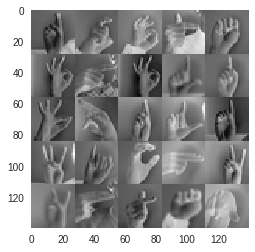

In [17]:
image_grid = train_images[:25].reshape(5, 5, HEIGHT, WIDTH)
image_grid = np.concatenate(image_grid, axis=1)
image_grid = np.concatenate(image_grid, axis=1)
plt.imshow(image_grid)
plt.grid(False)

In [0]:
train_vectors = train_images

## Batch function for retrieving examples

In [0]:
def batch(batch_size, train_vectors):
  """Create a random batch of examples.
    
  Args:
    batch_size: An integer.
  
  Returns:
    input_batch: A Variable of floats with shape [batch_size, num_features]
  """
  random_ind = np.random.choice(train_vectors.shape[0], size=batch_size, replace=False)
  input_batch = train_vectors[random_ind]
  input_batch = Variable(torch.from_numpy(input_batch).cuda())
  return input_batch

**Decoder steps*

1. Map from our low-dimensional $\zb$ to a hidden layer of 128 units
2. Apply a ReLU nonlinearity
3. Map to a hidden layer of 512 hidden units
4. Apply a ReLU nonlinearity
5. Map to $\mub_x$ (which resides in $\mathbb{R}^{784}$)
6. (In addition, we return a fixed $\sigmab_x$, but this is already in place for you.)

In [0]:
class VAEDecoder(torch.nn.Module):

  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim
    self.linear_1 = torch.nn.Linear(z_dim, 128) 
    self.linear_2 = torch.nn.Linear(128, 512) 
    
    # Use this layer to go from 512 dimension to 784 for MNIST
    # Then sample pixel values using the mean and sigma provided
    self.linear_3 = torch.nn.Linear(512, HEIGHT * WIDTH) 

  def forward(self, z):
    h = F.relu(self.linear_1(z)) 
    h = F.relu(self.linear_2(h)) 
    mu_x = self.linear_3(h) 
    sigma_x = Variable(mu_x.data.new(mu_x.shape).fill_(0.1))
    return mu_x, sigma_x

  def log_p_x_given_z(self, mu_x, sigma_x, x):
    dist = torch.distributions.Normal(mu_x, sigma_x)
    return dist.log_prob(x).sum()

In [0]:
class VAEEncoder(torch.nn.Module):

  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim
    self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
    self.linear_1 = torch.nn.Linear(320, 128)
    self.linear_2 = torch.nn.Linear(128, 2 * z_dim) 

  def forward(self, x):
    x = x.view(-1,1,28,28)
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, 320)
    h = F.relu(self.linear_1(x))
    mu_and_pre_sigma = self.linear_2(h)
    mu_z, pre_sigma_z = torch.split(mu_and_pre_sigma, self.z_dim, dim=1) 
    sigma_z = F.softplus(pre_sigma_z) 
    return mu_z, sigma_z

  def rsample(self, mu_z, sigma_z):
    # If we truly sample, we break our (deterministic) computation graph.
    # This is the reparameterization trick: we sample from a standard
    # normal and transform it with mu_z and sigma_z so that we have
    # a well-defined computation graph (on which we can run backprop).
    standard_normal_samples = Variable(mu_z.data.new(mu_z.shape).normal_())
    scaled_samples = sigma_z * standard_normal_samples
    shifted_scaled_samples = scaled_samples + mu_z
    return shifted_scaled_samples

  def kl(self, mu_z, sigma_z):
    # This is the KL divergence KL( N(mu_z, diag(sigma_z)) || N(0, I) ) in closed form.
    # (It's not difficult to derive; try it!)
    kl_q_z_p_z = 0.5 * torch.sum(-2*torch.log(sigma_z) - 1 + sigma_z**2 + mu_z.pow(2))
    return kl_q_z_p_z

In [0]:
encoder = VAEEncoder(Z_DIM).cuda()
decoder = VAEDecoder(Z_DIM).cuda()

In [0]:
params = list(itertools.chain(encoder.parameters(), decoder.parameters()))
optimizer = torch.optim.Adam(params, 0.001)

In [0]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveClassifier
import pickle
import sys
from sklearn.externals import joblib
from sklearn.manifold import Isomap, LocallyLinearEmbedding

import warnings
warnings.filterwarnings("ignore")


def test_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield Variable(torch.from_numpy(iterable[ndx:min(ndx + n, l)]).cuda())

def train(samples, encoder, decoder, optimizer):
  mu_z, sigma_z = encoder(samples)
  z = encoder.rsample(mu_z, sigma_z)
  mu_x, sigma_x = decoder(z)
  neg_log_p_given_x = -decoder.log_p_x_given_z(mu_x, sigma_x, samples) / samples.shape[0]
  kl = encoder.kl(mu_z, sigma_z) / samples.shape[0]
  loss = neg_log_p_given_x + kl
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return neg_log_p_given_x.data[0], kl.data[0], loss.data[0]

def train_VAE(Z_DIM=398, NUM_STEPS = 10000,  BATCH_SIZE = 128):
#   classifiers = [(SGDClassifier(loss='hinge'), "Hinge Loss"),
#                  (SGDClassifier(loss='log'), "Log Loss"),
#                  (PassiveAggressiveClassifier(), "Passive Aggressive - Hinge"),
#                  (AdaBoostClassifier(), "AdaBoost"),
#                  (Perceptron(penalty='l2'), "Perceptron L2"),
#                  (RandomForestClassifier(n_jobs=-1), "Random Forest"),
#                  (QuadraticDiscriminantAnalysis(), "QDA"),
#                  (GradientBoostingClassifier(), "Gradient Boosting")]


  classifiers = [ (QuadraticDiscriminantAnalysis(), "QDA")]
  X_train_encoded = []
  X_test_encoded = []
  X_val_encoded = []

  encoder = VAEEncoder(Z_DIM).cuda()
  decoder = VAEDecoder(Z_DIM).cuda()
  params = list(itertools.chain(encoder.parameters(), decoder.parameters()))
  optimizer = torch.optim.Adam(params, 0.1e-3)
  loss_list = []
  for step in range(NUM_STEPS):
    samples = batch(BATCH_SIZE, X_train.astype(np.float32))
    loss_list.append(train(samples, encoder, decoder, optimizer))
    if step % 200 == 0:
      loss = loss_list[-1][2]
      print(f'Step {step:05d} / {NUM_STEPS:05d}. Loss: {loss:.2f}.')

  neg_log_p, kl, loss = zip(*loss_list)

  # X_test, y_test
  for samples in test_batch(X_test.astype(np.float32), BATCH_SIZE):  
    mu_z, sigma_z = encoder(samples)
    z = encoder.rsample(mu_z, sigma_z)
    X_test_encoded.extend(z.data.cpu().numpy())
  for samples in test_batch(X_train.astype(np.float32), BATCH_SIZE):  
    mu_z, sigma_z = encoder(samples)
    z = encoder.rsample(mu_z, sigma_z)
    X_train_encoded.extend(z.data.cpu().numpy())
  for samples in test_batch(X_val.astype(np.float32), BATCH_SIZE):  
    mu_z, sigma_z = encoder(samples)
    z = encoder.rsample(mu_z, sigma_z)
    X_val_encoded.extend(z.data.cpu().numpy())

  aname = "VAE " + str(Z_DIM)
  X_train_encoded = np.asarray(X_train_encoded)
  X_val_encoded = np.asarray(X_val_encoded)
  X_test_encoded = np.asarray(X_test_encoded)

  for clf, name in classifiers:
      clf.fit(X_train_encoded, y_train)
      print(aname, name, clf.score(X_train_encoded, y_train), clf.score(X_val_encoded, y_val),
            clf.score(X_test_encoded, y_test))
      sys.stdout.flush()




In [40]:
for n in [98]:
  train_VAE(n, 50000)

Step 00000 / 50000. Loss: 40866.79.
Step 00200 / 50000. Loss: 26547.49.
Step 00400 / 50000. Loss: 19350.93.
Step 00600 / 50000. Loss: 15822.58.
Step 00800 / 50000. Loss: 14385.38.
Step 01000 / 50000. Loss: 12093.38.
Step 01200 / 50000. Loss: 10068.16.
Step 01400 / 50000. Loss: 9696.37.
Step 01600 / 50000. Loss: 9778.93.
Step 01800 / 50000. Loss: 8317.34.
Step 02000 / 50000. Loss: 7426.39.
Step 02200 / 50000. Loss: 7426.47.
Step 02400 / 50000. Loss: 7621.23.
Step 02600 / 50000. Loss: 7323.16.
Step 02800 / 50000. Loss: 6629.58.
Step 03000 / 50000. Loss: 7269.63.
Step 03200 / 50000. Loss: 6244.31.
Step 03400 / 50000. Loss: 5979.57.
Step 03600 / 50000. Loss: 6344.28.
Step 03800 / 50000. Loss: 5954.51.
Step 04000 / 50000. Loss: 5461.16.
Step 04200 / 50000. Loss: 5551.82.
Step 04400 / 50000. Loss: 5398.35.
Step 04600 / 50000. Loss: 5413.67.
Step 04800 / 50000. Loss: 5532.99.
Step 05000 / 50000. Loss: 5087.30.
Step 05200 / 50000. Loss: 4672.81.
Step 05400 / 50000. Loss: 4900.68.
Step 05600 / 

Step 14800 / 50000. Loss: 2913.46.
Step 15000 / 50000. Loss: 2607.76.
Step 15200 / 50000. Loss: 2728.85.
Step 15400 / 50000. Loss: 2668.12.
Step 15600 / 50000. Loss: 2709.65.
Step 15800 / 50000. Loss: 2635.79.
Step 16000 / 50000. Loss: 2553.37.
Step 16200 / 50000. Loss: 2710.49.
Step 16400 / 50000. Loss: 2661.21.
Step 16600 / 50000. Loss: 2310.09.
Step 16800 / 50000. Loss: 2486.62.
Step 17000 / 50000. Loss: 2530.72.
Step 17200 / 50000. Loss: 2446.19.
Step 17400 / 50000. Loss: 2446.72.
Step 17600 / 50000. Loss: 2414.42.
Step 17800 / 50000. Loss: 2344.35.
Step 18000 / 50000. Loss: 2444.55.
Step 18200 / 50000. Loss: 2440.83.
Step 18400 / 50000. Loss: 2224.67.
Step 18600 / 50000. Loss: 2138.72.
Step 18800 / 50000. Loss: 2203.48.
Step 19000 / 50000. Loss: 1982.36.
Step 19200 / 50000. Loss: 2283.67.
Step 19400 / 50000. Loss: 2160.69.
Step 19600 / 50000. Loss: 2224.81.
Step 19800 / 50000. Loss: 2061.95.
Step 20000 / 50000. Loss: 2141.88.
Step 20200 / 50000. Loss: 2245.95.
Step 20400 / 50000. 

Step 29800 / 50000. Loss: 1664.49.
Step 30000 / 50000. Loss: 1481.14.
Step 30200 / 50000. Loss: 1391.94.
Step 30400 / 50000. Loss: 1623.36.
Step 30600 / 50000. Loss: 1613.87.
Step 30800 / 50000. Loss: 1584.19.
Step 31000 / 50000. Loss: 1446.82.
Step 31200 / 50000. Loss: 1558.89.
Step 31400 / 50000. Loss: 1608.51.
Step 31600 / 50000. Loss: 1457.22.
Step 31800 / 50000. Loss: 1629.04.
Step 32000 / 50000. Loss: 1623.11.
Step 32200 / 50000. Loss: 1588.56.
Step 32400 / 50000. Loss: 1489.98.
Step 32600 / 50000. Loss: 1466.89.
Step 32800 / 50000. Loss: 1597.23.
Step 33000 / 50000. Loss: 1400.97.
Step 33200 / 50000. Loss: 1496.60.
Step 33400 / 50000. Loss: 1430.40.
Step 33600 / 50000. Loss: 1494.91.
Step 33800 / 50000. Loss: 1495.17.
Step 34000 / 50000. Loss: 1570.33.
Step 34200 / 50000. Loss: 1566.38.
Step 34400 / 50000. Loss: 1316.03.
Step 34600 / 50000. Loss: 1429.21.
Step 34800 / 50000. Loss: 1416.99.
Step 35000 / 50000. Loss: 1409.69.
Step 35200 / 50000. Loss: 1347.00.
Step 35400 / 50000. 

Step 44800 / 50000. Loss: 1267.57.
Step 45000 / 50000. Loss: 1100.03.
Step 45200 / 50000. Loss: 1068.83.
Step 45400 / 50000. Loss: 1294.42.
Step 45600 / 50000. Loss: 1177.34.
Step 45800 / 50000. Loss: 1296.52.
Step 46000 / 50000. Loss: 1202.45.
Step 46200 / 50000. Loss: 1095.74.
Step 46400 / 50000. Loss: 1137.08.
Step 46600 / 50000. Loss: 1138.06.
Step 46800 / 50000. Loss: 1254.92.
Step 47000 / 50000. Loss: 1228.92.
Step 47200 / 50000. Loss: 986.78.
Step 47400 / 50000. Loss: 1103.40.
Step 47600 / 50000. Loss: 1188.51.
Step 47800 / 50000. Loss: 1172.36.
Step 48000 / 50000. Loss: 1140.50.
Step 48200 / 50000. Loss: 1038.67.
Step 48400 / 50000. Loss: 1065.75.
Step 48600 / 50000. Loss: 1026.82.
Step 48800 / 50000. Loss: 1148.22.
Step 49000 / 50000. Loss: 996.41.
Step 49200 / 50000. Loss: 1123.08.
Step 49400 / 50000. Loss: 1036.64.
Step 49600 / 50000. Loss: 1088.54.
Step 49800 / 50000. Loss: 1065.58.
VAE 98 QDA 1.0 1.0 0.8750697155605132


### Visualize generated images as we traverse $\zb$ space from one image to another

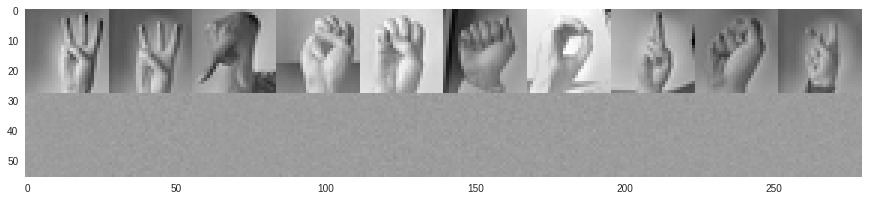

In [45]:
samples = batch(10, X_train.astype(np.float32))

mu_z, sigma_z = encoder(samples)
z = encoder.rsample(mu_z, sigma_z)
mu_x, sigma_x = decoder(z)

samples = samples.view(-1, HEIGHT, WIDTH).data.cpu().numpy()
samples = np.concatenate(samples, axis=1)
mu_x = mu_x.view(-1, HEIGHT, WIDTH).data.cpu().numpy()
mu_x = np.concatenate(mu_x, axis=1)
plt.figure(figsize=(15, 5))
plt.set_cmap('gray')
plt.imshow(np.concatenate([samples, mu_x], axis=0))

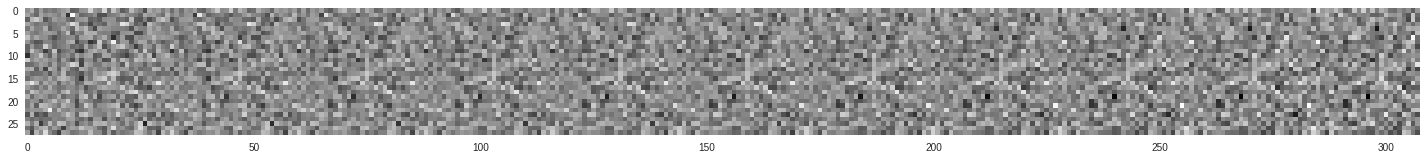

In [44]:
z_1 = z[1] 
z_7 = z[2] 
mixture_coefs = Variable(torch.arange(0.0, 1.0, 0.1).cuda()).view(-1, 1)
z_interp = (1.0 - mixture_coefs)**.5 * z_1 + mixture_coefs**.5 * z_7
mu_x, sigma_x = decoder(z_interp) 
mu_x = mu_x.view(-1, HEIGHT, WIDTH).data.cpu().numpy() 
mu_x = np.concatenate(mu_x, axis=1) 
plt.figure(figsize=(25, 5))
plt.set_cmap('gray')
plt.imshow(mu_x)